In [1]:
import numpy as np

np.set_printoptions(precision=4, suppress=True, linewidth=132)


def setup_system(energy_separation=0.5, verbose=False, n=10):

    E_0 = 1.5
    Phi_0 = np.zeros(n)
    Phi_0[0] = 1

    H_0_diag = np.arange(E_0, E_0 + energy_separation * n, energy_separation)
    H_0 = np.diag(H_0_diag)

    np.random.seed(20220526)
    V = -0.1 * np.diag(np.random.rand(n) * 0.1)
    for i in range(2, n):
        V[i - 2 : i, i] = np.random.rand(2) * 0.25
    V = V + V.T

    H = H_0 + V

    eigval, _ = np.linalg.eigh(H)
    E_exact = eigval.min()

    # M = P * (H_0 - E_0)^{-1} * P
    M_diag = H_0_diag - E_0
    M_diag[0] = 1
    M = np.diag(1 / M_diag)
    M[0, 0] = 0

    E = [E_0]
    Psi = [Phi_0]

    if verbose:
        print(H)

    return E_exact, E, Psi, V, M

In [2]:
E_exact, E, Psi, V, M = setup_system(energy_separation=0.5, verbose=True, n=10)

[[1.4931 0.     0.1577 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.9948 0.2499 0.0431 0.     0.     0.     0.     0.     0.    ]
 [0.1577 0.2499 2.4836 0.1796 0.2426 0.     0.     0.     0.     0.    ]
 [0.     0.0431 0.1796 2.9848 0.1341 0.2125 0.     0.     0.     0.    ]
 [0.     0.     0.2426 0.1341 3.4843 0.2393 0.0742 0.     0.     0.    ]
 [0.     0.     0.     0.2125 0.2393 3.9982 0.1831 0.0795 0.     0.    ]
 [0.     0.     0.     0.     0.0742 0.1831 4.492  0.2116 0.2425 0.    ]
 [0.     0.     0.     0.     0.     0.0795 0.2116 4.9965 0.1532 0.0945]
 [0.     0.     0.     0.     0.     0.     0.2425 0.1532 5.4865 0.2328]
 [0.     0.     0.     0.     0.     0.     0.     0.0945 0.2328 5.9925]]


In [3]:
def rspt_solver(E_exact, E, Psi, V, M, verbose=False):

    error = [E[0] - E_exact]

    if verbose:
        print(" n   RSPT energy    Error")
        print(f" 0 {E[0]:12.8f} {error[0]:14.8f}")

    for m in range(1, 10):

        E.append(np.einsum("i,ij,j", Psi[0], V, Psi[m - 1]))
        error.append(np.array(E).sum() - E_exact)

        R = np.einsum("ij,j->i", V, Psi[m - 1])
        for k in range(1, m):
            R -= E[k] * Psi[m - k]

        Psi.append(np.einsum("ij,j->i", -M, R))

        if verbose:
            print(f"{m:2} {np.array(E).sum():12.8f} {error[-1]:14.8f}")

    return E, error

In [4]:
_ = rspt_solver(E_exact, E, Psi, V, M, True)

 n   RSPT energy    Error
 0   1.50000000     0.03590812
 1   1.49306122     0.02896934
 2   1.46820039     0.00410850
 3   1.46796433     0.00387245
 4   1.46420937     0.00011749
 5   1.46437373     0.00028185
 6   1.46401910    -0.00007279
 7   1.46407353    -0.00001836
 8   1.46407816    -0.00001372
 9   1.46408390    -0.00000798


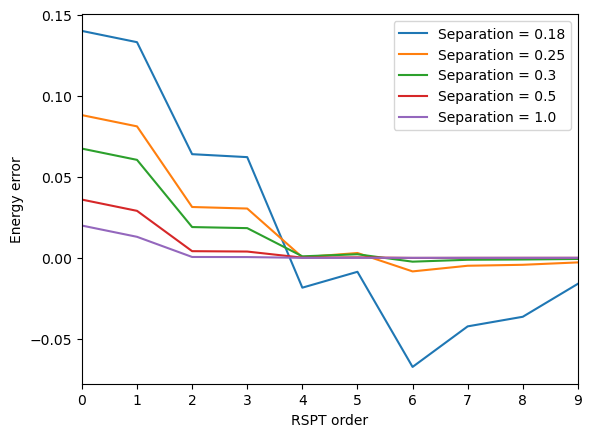

In [5]:
import matplotlib.pyplot as plt

for energy_separation in [0.18, 0.25, 0.3, 0.5, 1.0]:

    E_exact, E, Psi, V, M = setup_system(energy_separation, False, 10)
    E, error = rspt_solver(E_exact, E, Psi, V, M, False)

    plt.plot(range(10), error, label=f"Separation = {energy_separation:.2}")
    
plt.legend()
plt.setp(plt.gca(), xlim=(0, 9), xticks=range(10))

plt.ylabel("Energy error")
plt.xlabel("RSPT order")

plt.show()